# Baseline RGB - EfficientNet-B0
## Beyond Visible Spectrum: AI for Agriculture 2026

**Pipeline:**
1. EDA & Data Loading
2. Dataset & DataLoader
3. Model: EfficientNet-B0 pretrained
4. Training với WandB logging
5. Evaluation & Confusion Matrix
6. Inference & Submission

## 1. Imports & Config

In [10]:
import os
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from collections import Counter, defaultdict

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.models as models
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader, Subset
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

import wandb

# Config
CONFIG = {
    "seed": 42,
    "img_size": 224,  # ConvNeXt prefers 224x224
    "batch_size": 32,
    "epochs": 10,
    "lr": 1e-4,
    "val_split": 0.2,
    "num_classes": 3,
    "model_name": "convnext_tiny",
}

# Paths - LOCAL
TRAIN_RGB_DIR = r"G:\My Drive\NCKH\git\dataset\train\RGB"
TEST_RGB_DIR = r"G:\My Drive\NCKH\git\dataset\val\RGB"
CHECKPOINT_DIR = r"G:\My Drive\NCKH\git\checkpoints"

# # Paths - KAGGLE
# TRAIN_RGB_DIR = "/kaggle/input/beyond-visible-spectrum/train/RGB"
# TEST_RGB_DIR = "/kaggle/input/beyond-visible-spectrum/test/RGB"
# CHECKPOINT_DIR = "/kaggle/working"

device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Device: {device}")

# Set seed
np.random.seed(CONFIG["seed"])
torch.manual_seed(CONFIG["seed"])


Device: cuda


## 2. EDA - Exploratory Data Analysis

Total images: 600
Classes: {'Health': 200, 'Other': 200, 'Rust': 200}


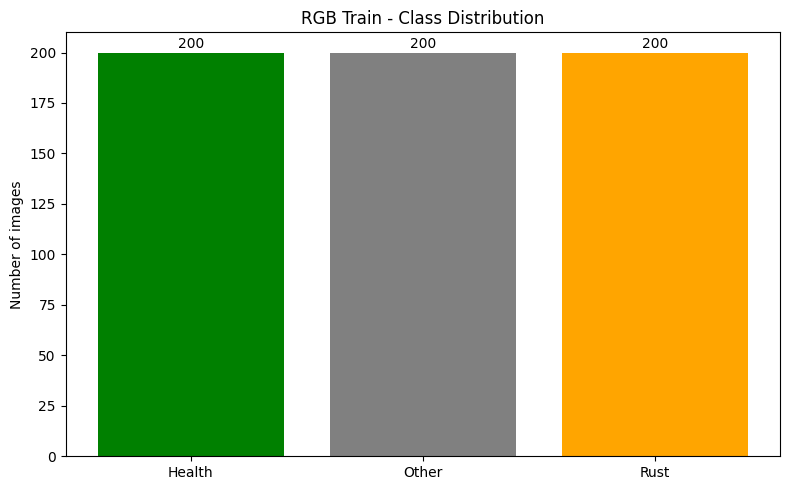

In [11]:
def label_from_filename(fname: str) -> str:
    """Extract label from filename: 'Rust_hyper_184.png' -> 'Rust'"""
    return os.path.basename(fname).split("_")[0]

# Count images per class
files = [f for f in os.listdir(TRAIN_RGB_DIR) if f.lower().endswith(".png")]
class_counts = Counter(label_from_filename(f) for f in files)

print(f"Total images: {len(files)}")
print(f"Classes: {dict(class_counts)}")

# Plot distribution
plt.figure(figsize=(8, 5))
classes = sorted(class_counts.keys())
counts = [class_counts[c] for c in classes]
plt.bar(classes, counts, color=['green', 'gray', 'orange'])
plt.ylabel('Number of images')
plt.title('RGB Train - Class Distribution')
for i, v in enumerate(counts):
    plt.text(i, v + 2, str(v), ha='center')
plt.tight_layout()
plt.show()

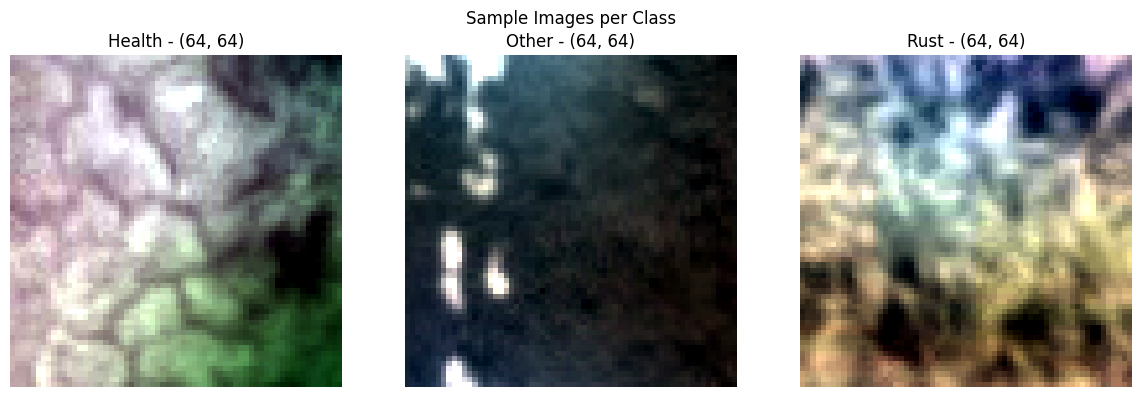

In [12]:
# Show sample images
fig, axes = plt.subplots(1, 3, figsize=(12, 4))

for i, cls in enumerate(classes):
    sample_file = [f for f in files if label_from_filename(f) == cls][0]
    img = Image.open(os.path.join(TRAIN_RGB_DIR, sample_file))
    axes[i].imshow(img)
    axes[i].set_title(f"{cls} - {img.size}")
    axes[i].axis('off')

plt.suptitle('Sample Images per Class')
plt.tight_layout()
plt.show()

## 3. Dataset & DataLoader

In [13]:
class RGBDataset(Dataset):
    """RGB Image Dataset - loads PNG images with labels from filename"""
    
    def __init__(self, img_dir, transform=None, file_list=None):
        self.img_dir = img_dir
        self.transform = transform
        
        if file_list is not None:
            self.files = file_list
        else:
            self.files = sorted([f for f in os.listdir(img_dir) if f.lower().endswith(".png")])
        
        # Create label mapping
        labels = sorted({label_from_filename(f) for f in self.files})
        self.class_to_idx = {c: i for i, c in enumerate(labels)}
        self.idx_to_class = {i: c for c, i in self.class_to_idx.items()}
        self.y = [self.class_to_idx[label_from_filename(f)] for f in self.files]
    
    def __len__(self):
        return len(self.files)
    
    def __getitem__(self, idx):
        fname = self.files[idx]
        label = self.y[idx]
        
        img_path = os.path.join(self.img_dir, fname)
        img = Image.open(img_path).convert("RGB")
        
        if self.transform:
            img = self.transform(img)
        
        return img, label


class RGBTestDataset(Dataset):
    """RGB Test Dataset - returns image and filename (no label)"""
    
    def __init__(self, img_dir, transform=None):
        self.img_dir = img_dir
        self.transform = transform
        self.files = sorted([f for f in os.listdir(img_dir) if f.lower().endswith(".png")])
    
    def __len__(self):
        return len(self.files)
    
    def __getitem__(self, idx):
        fname = self.files[idx]
        img_path = os.path.join(self.img_dir, fname)
        img = Image.open(img_path).convert("RGB")
        
        if self.transform:
            img = self.transform(img)
        
        return img, fname

In [14]:
# ============================================================================
# AUGMENTATION STRATEGIES - VET QUA CÁC TỔ HỢP KHÁC NHAU
# ============================================================================

from itertools import combinations
import json

# Định nghĩa các augmentation có sẵn
AUGMENTATION_REGISTRY = {
    "HorizontalFlip": lambda: transforms.RandomHorizontalFlip(p=0.5),
    "VerticalFlip": lambda: transforms.RandomVerticalFlip(p=0.5),
    "Rotation15": lambda: transforms.RandomRotation(15),
    "Rotation30": lambda: transforms.RandomRotation(30),
    "ColorJitter_light": lambda: transforms.ColorJitter(brightness=0.1, contrast=0.1),
    "ColorJitter_med": lambda: transforms.ColorJitter(brightness=0.2, contrast=0.2),
    "ColorJitter_heavy": lambda: transforms.ColorJitter(brightness=0.3, contrast=0.3),
    "GaussianBlur": lambda: transforms.GaussianBlur(kernel_size=3, sigma=(0.1, 2.0)),
    "RandomAffine": lambda: transforms.RandomAffine(degrees=30, translate=(0.1, 0.1)),
    "RandomPerspective": lambda: transforms.RandomPerspective(distortion_scale=0.2, p=0.5),
}

print("=" * 80)
print("CÁC AUGMENTATION CÓ SẴN:")
print("=" * 80)
for i, aug_name in enumerate(AUGMENTATION_REGISTRY.keys(), 1):
    print(f"{i:2d}. {aug_name}")

# ============================================================================
# TẠO CÁC TỔ HỢP AUGMENTATION
# ============================================================================

def create_augmentation_combinations(min_size=1, max_size=None):
    """Tạo tất cả tổ hợp augmentation từ min_size đến max_size
    
    Args:
        min_size: Tối thiểu số augmentation trong mỗi tổ hợp
        max_size: Tối đa số augmentation trong mỗi tổ hợp (None = sử dụng tất cả)
    """
    aug_names = list(AUGMENTATION_REGISTRY.keys())
    n_augs = len(aug_names)
    
    if max_size is None:
        max_size = n_augs
    
    all_combos = []
    
    for combo_size in range(min_size, min(max_size + 1, n_augs + 1)):
        for combo in combinations(aug_names, combo_size):
            all_combos.append(list(combo))
    
    return all_combos

# ⚙️ CONFIGURATION: Thay đổi max_size để kiểm soát số tổ hợp
# max_size=4  → ~385 tổ hợp (nhanh)
# max_size=10 → ~1023 tổ hợp (TOÀN BỘ)
all_aug_combos = create_augmentation_combinations(min_size=1, max_size=10)  # Vét TOÀN BỘ

print(f"\n{'=' * 80}")
print(f"TỔNG TỔ HỢP: {len(all_aug_combos)} tổ hợp")
print(f"{'=' * 80}\n")

# In một số tổ hợp mẫu
print("Một số tổ hợp mẫu:")
for i, combo in enumerate(all_aug_combos[:10], 1):
    print(f"{i:3d}. {' + '.join(combo)}")
print(f"... và {len(all_aug_combos) - 10} tổ hợp khác")

# ============================================================================
# FUNCTION: TẠO TRANSFORM TỪ COMBO
# ============================================================================

def create_transforms_from_combo(aug_names, img_size=64):
    """Tạo transform pipeline từ danh sách augmentation names"""
    augmentations = [transforms.Resize((img_size, img_size))]
    
    for aug_name in aug_names:
        if aug_name in AUGMENTATION_REGISTRY:
            augmentations.append(AUGMENTATION_REGISTRY[aug_name]())
    
    augmentations.extend([
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], 
                            std=[0.229, 0.224, 0.225])
    ])
    
    return transforms.Compose(augmentations)

# ============================================================================
# K-Fold Stratified Split (GIỮ NGUYÊN)
# ============================================================================

from sklearn.model_selection import StratifiedKFold

base_ds = RGBDataset(TRAIN_RGB_DIR, transform=None)
n_splits = 5  # K-fold value
skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=CONFIG["seed"])

# Create K-fold splits
kfold_splits = []
for fold_idx, (train_idx, val_idx) in enumerate(skf.split(np.zeros(len(base_ds)), base_ds.y)):
    train_files = [base_ds.files[i] for i in train_idx]
    val_files = [base_ds.files[i] for i in val_idx]
    kfold_splits.append((train_files, val_files))

print(f"✓ Created {n_splits}-Fold splits")
for i, (train_files, val_files) in enumerate(kfold_splits):
    print(f"  Fold {i+1}: Train={len(train_files)}, Val={len(val_files)}")

# Data structure để lưu kết quả
augmentation_results = {
    "aug_combo": [],           # ["HorizontalFlip", "ColorJitter_med"]
    "avg_val_acc": [],         # Trung bình val_acc trên 5 folds
    "std_val_acc": [],         # Độ lệch chuẩn
    "avg_train_acc": [],       # Trung bình train_acc
    "all_fold_val_acc": [],    # [[fold1, fold2, fold3, fold4, fold5], ...]
}

CÁC AUGMENTATION CÓ SẴN:
 1. HorizontalFlip
 2. VerticalFlip
 3. Rotation15
 4. Rotation30
 5. ColorJitter_light
 6. ColorJitter_med
 7. ColorJitter_heavy
 8. GaussianBlur
 9. RandomAffine
10. RandomPerspective

TỔNG TỔ HỢP: 1023 tổ hợp

Một số tổ hợp mẫu:
  1. HorizontalFlip
  2. VerticalFlip
  3. Rotation15
  4. Rotation30
  5. ColorJitter_light
  6. ColorJitter_med
  7. ColorJitter_heavy
  8. GaussianBlur
  9. RandomAffine
 10. RandomPerspective
... và 1013 tổ hợp khác
✓ Created 5-Fold splits
  Fold 1: Train=480, Val=120
  Fold 2: Train=480, Val=120
  Fold 3: Train=480, Val=120
  Fold 4: Train=480, Val=120
  Fold 5: Train=480, Val=120


## 4. Model Definition

In [15]:
from torchvision import models
import torch.nn as nn

def create_model(num_classes, model_name="convnext_tiny", pretrained=True):
    """
    Create model with pretrained weights
    
    Args:
        num_classes: Number of output classes
        model_name: Model architecture ('convnext_tiny', 'convnext_base', 'efficientnet_b0')
        pretrained: Whether to use pretrained weights
    """
    if model_name == "convnext_tiny":
        if pretrained:
            weights = models.ConvNeXt_Tiny_Weights.DEFAULT
        else:
            weights = None
        model = models.convnext_tiny(weights=weights)
        
        # ConvNeXt: classifier is Sequential with [Linear, Linear]
        # We need to replace the last Linear layer
        in_features = model.classifier[2].in_features
        model.classifier[2] = nn.Linear(in_features, num_classes)
    
    elif model_name == "convnext_base":
        if pretrained:
            weights = models.ConvNeXt_Base_Weights.DEFAULT
        else:
            weights = None
        model = models.convnext_base(weights=weights)
        
        in_features = model.classifier[2].in_features
        model.classifier[2] = nn.Linear(in_features, num_classes)
    
    elif model_name == "efficientnet_b0":
        if pretrained:
            weights = models.EfficientNet_B0_Weights.DEFAULT
        else:
            weights = None
        model = models.efficientnet_b0(weights=weights)
        
        # EfficientNet: classifier is Sequential with [Dropout, Linear]
        in_features = model.classifier[1].in_features
        model.classifier[1] = nn.Linear(in_features, num_classes)
    
    else:
        raise ValueError(f"Unknown model: {model_name}")
    
    return model

# Use ConvNeXt Tiny (faster) or ConvNeXt Base (more accurate)
model = create_model(
    num_classes=CONFIG["num_classes"],
    model_name="convnext_tiny",  # Change to "convnext_base" for better accuracy
    pretrained=True
)
model = model.to(device)

print(f"Model: ConvNeXt Tiny")
print(f"Parameters: {sum(p.numel() for p in model.parameters()):,}")


Downloading: "https://download.pytorch.org/models/convnext_tiny-983f1562.pth" to C:\Users\DANG KHOA/.cache\torch\hub\checkpoints\convnext_tiny-983f1562.pth
100%|██████████| 109M/109M [00:07<00:00, 14.3MB/s] 


Model: ConvNeXt Tiny
Parameters: 27,822,435


In [18]:
def train_one_epoch(model, loader, criterion, optimizer):
    """Train for one epoch"""
    model.train()
    total_loss, correct, total = 0.0, 0, 0
    
    for images, labels in loader:
        images, labels = images.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item() * images.size(0)
        preds = outputs.argmax(dim=1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)
    
    return total_loss / total, correct / total


@torch.no_grad()
def evaluate(model, loader, criterion):
    """Evaluate model"""
    model.eval()
    total_loss, correct, total = 0.0, 0, 0
    
    for images, labels in loader:
        images, labels = images.to(device), labels.to(device)
        
        outputs = model(images)
        loss = criterion(outputs, labels)
        
        total_loss += loss.item() * images.size(0)
        preds = outputs.argmax(dim=1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)
    
    return total_loss / total, correct / total

In [16]:
## 3.5 Augmentation Grid Search - VET QUA TỪ HỢP


In [20]:
# ============================================================================
# CHỌN CÁC TỔ HỢP CẦN VÉT - TỐI ƯU HÓA VỚI AUGMENTATION MẠNH
# ============================================================================

# Selected comprehensive augmentation combinations - optimized & strong
selected_combos = [
    # 1. Baseline (1)
    [],
    
    # 2. Augmentation đơn lẻ (10)
    ["HorizontalFlip"],
    ["VerticalFlip"],
    ["Rotation15"],
    ["Rotation30"],
    ["ColorJitter_light"],
    ["ColorJitter_med"],
    ["ColorJitter_heavy"],
    ["GaussianBlur"],
    ["RandomAffine"],
    
    # 3. Tổ hợp 2 augmentation (20)
    ["HorizontalFlip", "VerticalFlip"],
    ["HorizontalFlip", "Rotation15"],
    ["HorizontalFlip", "Rotation30"],
    ["HorizontalFlip", "ColorJitter_med"],
    ["HorizontalFlip", "ColorJitter_heavy"],
    ["HorizontalFlip", "GaussianBlur"],
    ["VerticalFlip", "Rotation15"],
    ["VerticalFlip", "ColorJitter_med"],
    ["Rotation15", "ColorJitter_med"],
    ["Rotation30", "ColorJitter_med"],
    ["ColorJitter_med", "GaussianBlur"],
    ["HorizontalFlip", "RandomAffine"],
    ["VerticalFlip", "RandomAffine"],
    ["Rotation15", "RandomAffine"],
    ["ColorJitter_med", "RandomAffine"],
    ["Rotation15", "GaussianBlur"],
    ["Rotation30", "GaussianBlur"],
    ["HorizontalFlip", "RandomPerspective"],
    ["Rotation15", "RandomPerspective"],
    ["ColorJitter_med", "RandomPerspective"],
    
    # 4. Tổ hợp 3 augmentation (35)
    ["HorizontalFlip", "VerticalFlip", "Rotation15"],
    ["HorizontalFlip", "VerticalFlip", "Rotation30"],
    ["HorizontalFlip", "VerticalFlip", "ColorJitter_med"],
    ["HorizontalFlip", "VerticalFlip", "ColorJitter_heavy"],
    ["HorizontalFlip", "VerticalFlip", "GaussianBlur"],
    ["HorizontalFlip", "Rotation15", "ColorJitter_light"],
    ["HorizontalFlip", "Rotation15", "ColorJitter_med"],
    ["HorizontalFlip", "Rotation15", "ColorJitter_heavy"],
    ["HorizontalFlip", "Rotation15", "GaussianBlur"],
    ["HorizontalFlip", "Rotation30", "ColorJitter_med"],
    ["HorizontalFlip", "Rotation30", "GaussianBlur"],
    ["HorizontalFlip", "ColorJitter_light", "GaussianBlur"],
    ["HorizontalFlip", "ColorJitter_med", "GaussianBlur"],
    ["HorizontalFlip", "ColorJitter_heavy", "GaussianBlur"],
    ["VerticalFlip", "Rotation15", "ColorJitter_med"],
    ["VerticalFlip", "Rotation15", "GaussianBlur"],
    ["VerticalFlip", "ColorJitter_med", "GaussianBlur"],
    ["Rotation15", "Rotation30", "ColorJitter_med"],
    ["Rotation15", "ColorJitter_med", "GaussianBlur"],
    ["Rotation15", "ColorJitter_heavy", "GaussianBlur"],
    ["Rotation30", "ColorJitter_med", "GaussianBlur"],
    ["HorizontalFlip", "Rotation15", "RandomAffine"],
    ["HorizontalFlip", "Rotation30", "RandomAffine"],
    ["HorizontalFlip", "ColorJitter_med", "RandomAffine"],
    ["VerticalFlip", "Rotation15", "RandomAffine"],
    ["Rotation15", "ColorJitter_med", "RandomAffine"],
    ["HorizontalFlip", "ColorJitter_med", "RandomPerspective"],
    ["VerticalFlip", "ColorJitter_med", "RandomPerspective"],
    ["Rotation15", "ColorJitter_med", "RandomPerspective"],
    ["HorizontalFlip", "VerticalFlip", "RandomAffine"],
    ["HorizontalFlip", "VerticalFlip", "RandomPerspective"],
    ["Rotation15", "Rotation30", "GaussianBlur"],
    ["Rotation15", "GaussianBlur", "RandomAffine"],
    ["ColorJitter_heavy", "GaussianBlur", "RandomAffine"],
    ["HorizontalFlip", "GaussianBlur", "RandomPerspective"],
    
    # 5. Tổ hợp 4 augmentation - MẠNH & ĐỦ THÁCH THỨC (30)
    ["HorizontalFlip", "VerticalFlip", "Rotation15", "ColorJitter_med"],
    ["HorizontalFlip", "VerticalFlip", "Rotation15", "ColorJitter_heavy"],
    ["HorizontalFlip", "VerticalFlip", "Rotation15", "GaussianBlur"],
    ["HorizontalFlip", "VerticalFlip", "Rotation30", "ColorJitter_med"],
    ["HorizontalFlip", "VerticalFlip", "Rotation30", "GaussianBlur"],
    ["HorizontalFlip", "VerticalFlip", "ColorJitter_med", "GaussianBlur"],
    ["HorizontalFlip", "Rotation15", "ColorJitter_med", "GaussianBlur"],
    ["HorizontalFlip", "Rotation15", "ColorJitter_heavy", "GaussianBlur"],
    ["HorizontalFlip", "Rotation30", "ColorJitter_med", "GaussianBlur"],
    ["VerticalFlip", "Rotation15", "ColorJitter_med", "GaussianBlur"],
    ["Rotation15", "Rotation30", "ColorJitter_med", "GaussianBlur"],
    ["HorizontalFlip", "VerticalFlip", "Rotation15", "RandomAffine"],
    ["HorizontalFlip", "VerticalFlip", "ColorJitter_med", "RandomAffine"],
    ["HorizontalFlip", "Rotation15", "ColorJitter_med", "RandomAffine"],
    ["VerticalFlip", "Rotation15", "ColorJitter_med", "RandomAffine"],
    ["Rotation15", "ColorJitter_med", "GaussianBlur", "RandomAffine"],
    ["HorizontalFlip", "VerticalFlip", "ColorJitter_heavy", "RandomAffine"],
    ["HorizontalFlip", "Rotation30", "ColorJitter_heavy", "RandomAffine"],
    ["HorizontalFlip", "VerticalFlip", "ColorJitter_med", "RandomPerspective"],
    ["HorizontalFlip", "ColorJitter_med", "RandomAffine", "RandomPerspective"],
    ["Rotation15", "ColorJitter_med", "RandomAffine", "RandomPerspective"],
    ["HorizontalFlip", "Rotation15", "ColorJitter_heavy", "RandomPerspective"],
    ["VerticalFlip", "Rotation15", "ColorJitter_med", "RandomPerspective"],
    ["HorizontalFlip", "VerticalFlip", "GaussianBlur", "RandomAffine"],
    ["HorizontalFlip", "VerticalFlip", "GaussianBlur", "RandomPerspective"],
    ["Rotation15", "ColorJitter_heavy", "GaussianBlur", "RandomAffine"],
    ["HorizontalFlip", "Rotation30", "ColorJitter_heavy", "GaussianBlur"],
    ["HorizontalFlip", "VerticalFlip", "Rotation30", "ColorJitter_heavy"],
    ["Rotation15", "Rotation30", "ColorJitter_heavy", "GaussianBlur"],
    ["HorizontalFlip", "ColorJitter_heavy", "GaussianBlur", "RandomPerspective"],
    
    # 6. Tổ hợp 5 augmentation - CỰC MẠNH (10)
    ["HorizontalFlip", "VerticalFlip", "Rotation15", "ColorJitter_med", "GaussianBlur"],
    ["HorizontalFlip", "VerticalFlip", "Rotation30", "ColorJitter_heavy", "GaussianBlur"],
    ["HorizontalFlip", "Rotation15", "ColorJitter_heavy", "GaussianBlur", "RandomAffine"],
    ["HorizontalFlip", "VerticalFlip", "Rotation15", "ColorJitter_med", "RandomAffine"],
    ["HorizontalFlip", "VerticalFlip", "Rotation30", "ColorJitter_med", "RandomAffine"],
    ["Rotation15", "Rotation30", "ColorJitter_heavy", "GaussianBlur", "RandomAffine"],
    ["HorizontalFlip", "VerticalFlip", "Rotation15", "ColorJitter_heavy", "RandomPerspective"],
    ["HorizontalFlip", "Rotation15", "ColorJitter_heavy", "RandomAffine", "RandomPerspective"],
    ["HorizontalFlip", "VerticalFlip", "Rotation30", "ColorJitter_heavy", "RandomAffine"],
    ["Rotation15", "ColorJitter_heavy", "GaussianBlur", "RandomAffine", "RandomPerspective"],
]

print(f"✓ MODE: VÉT TỐI ƯU HÓA 106 TỔ HỢP MẠNH NHẤT - {len(selected_combos)} tổ hợp\n")
print(f"  • 1 Baseline")
print(f"  • 10 Augmentation đơn lẻ") 
print(f"  • 20 Tổ hợp 2 augmentation")
print(f"  • 35 Tổ hợp 3 augmentation")
print(f"  • 30 Tổ hợp 4 augmentation (MẠNH HƠN)")
print(f"  • 10 Tổ hợp 5 augmentation (CỰC MẠNH)\n")

print(f"{'=' * 80}")
print(f"SẼ VÉT QUA {len(selected_combos)} TỔ HỢP")
print(f"{'=' * 80}\n")

# In danh sách (giới hạn nếu quá nhiều)
if len(selected_combos) <= 50:
    for i, combo in enumerate(selected_combos, 1):
        combo_name = ' + '.join(combo) if combo else "NO AUGMENTATION"
        print(f"{i:2d}. {combo_name}")
else:
    # In 10 đầu tiên
    for i, combo in enumerate(selected_combos[:10], 1):
        combo_name = ' + '.join(combo) if combo else "NO AUGMENTATION"
        print(f"{i:2d}. {combo_name}")
    print(f"... ({len(selected_combos) - 10} tổ hợp khác)")
    # In 5 cuối cùng
    print("...")
    for i, combo in enumerate(selected_combos[-5:], len(selected_combos) - 4):
        combo_name = ' + '.join(combo) if combo else "NO AUGMENTATION"
        print(f"{i:2d}. {combo_name}")

print(f"\n{'=' * 80}\n")

# ============================================================================
# TRAINING LOOP - VÉT QUA CÁC TỔ HỢP AUGMENTATION
# ============================================================================

import time
from datetime import datetime

start_time = time.time()
total_combos = len(selected_combos)

for combo_idx, aug_combo in enumerate(selected_combos, 1):
    combo_name = ' + '.join(aug_combo) if aug_combo else "NO_AUG"
    
    print(f"\n{'=' * 90}")
    print(f"[{combo_idx}/{total_combos}] TESTING AUGMENTATION: {combo_name}")
    print(f"{'=' * 90}\n")
    
    # Tạo transforms cho combo này
    tfm_train_combo = create_transforms_from_combo(aug_combo, CONFIG["img_size"])
    tfm_val = transforms.Compose([
        transforms.Resize((CONFIG["img_size"], CONFIG["img_size"])),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])
    
    # Lưu kết quả của combo này trên tất cả folds
    fold_val_accs = []
    fold_train_accs = []
    
    # Training trên các fold
    for fold_idx, (train_files, val_files) in enumerate(kfold_splits, 1):
        # Create datasets for this fold
        train_ds = RGBDataset(TRAIN_RGB_DIR, transform=tfm_train_combo, file_list=train_files)
        val_ds = RGBDataset(TRAIN_RGB_DIR, transform=tfm_val, file_list=val_files)
        
        # DataLoaders
        train_loader = DataLoader(train_ds, batch_size=CONFIG["batch_size"], shuffle=True, num_workers=0)
        val_loader = DataLoader(val_ds, batch_size=CONFIG["batch_size"], shuffle=False, num_workers=0)
        
        # Reinitialize model
        model = create_model(CONFIG["num_classes"], pretrained=True)
        model = model.to(device)
        
        # Loss & Optimizer
        criterion = nn.CrossEntropyLoss()
        optimizer = optim.Adam(model.parameters(), lr=CONFIG["lr"])
        scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=3)
        
        # Training loop
        best_val_acc = 0.0
        best_train_acc_at_best_val = 0.0
        
        for epoch in range(1, CONFIG["epochs"] + 1):
            train_loss, train_acc = train_one_epoch(model, train_loader, criterion, optimizer)
            val_loss, val_acc = evaluate(model, val_loader, criterion)
            
            scheduler.step(val_acc)
            
            if val_acc > best_val_acc:
                best_val_acc = val_acc
                best_train_acc_at_best_val = train_acc
                print(f"  Fold {fold_idx} | Epoch {epoch:02d} | train_acc={train_acc:.4f} val_acc={val_acc:.4f} ⭐")
            else:
                print(f"  Fold {fold_idx} | Epoch {epoch:02d} | train_acc={train_acc:.4f} val_acc={val_acc:.4f}")
        
        fold_val_accs.append(best_val_acc)
        fold_train_accs.append(best_train_acc_at_best_val)
    
    # Tính toán thống kê
    avg_val_acc = np.mean(fold_val_accs)
    std_val_acc = np.std(fold_val_accs)
    avg_train_acc = np.mean(fold_train_accs)
    
    # Lưu kết quả
    augmentation_results["aug_combo"].append(aug_combo)
    augmentation_results["avg_val_acc"].append(avg_val_acc)
    augmentation_results["std_val_acc"].append(std_val_acc)
    augmentation_results["avg_train_acc"].append(avg_train_acc)
    augmentation_results["all_fold_val_acc"].append(fold_val_accs)
    
    print(f"\n✓ AUGMENTATION: {combo_name}")
    print(f"  Mean Val Accuracy: {avg_val_acc:.4f} ± {std_val_acc:.4f}")
    print(f"  Mean Train Accuracy: {avg_train_acc:.4f}")
    print(f"  Fold Results: {[f'{acc:.4f}' for acc in fold_val_accs]}")
    print(f"  Progress: {combo_idx}/{total_combos}")

elapsed_time = time.time() - start_time
print(f"\n{'=' * 90}")
print(f"✓ VÉT HOÀN THÀNH trong {elapsed_time/60:.2f} phút")
print(f"{'=' * 90}\n")


✓ MODE: VÉT TỐI ƯU HÓA 106 TỔ HỢP MẠNH NHẤT - 105 tổ hợp

  • 1 Baseline
  • 10 Augmentation đơn lẻ
  • 20 Tổ hợp 2 augmentation
  • 35 Tổ hợp 3 augmentation
  • 30 Tổ hợp 4 augmentation (MẠNH HƠN)
  • 10 Tổ hợp 5 augmentation (CỰC MẠNH)

SẼ VÉT QUA 105 TỔ HỢP

 1. NO AUGMENTATION
 2. HorizontalFlip
 3. VerticalFlip
 4. Rotation15
 5. Rotation30
 6. ColorJitter_light
 7. ColorJitter_med
 8. ColorJitter_heavy
 9. GaussianBlur
10. RandomAffine
... (95 tổ hợp khác)
...
101. Rotation15 + Rotation30 + ColorJitter_heavy + GaussianBlur + RandomAffine
102. HorizontalFlip + VerticalFlip + Rotation15 + ColorJitter_heavy + RandomPerspective
103. HorizontalFlip + Rotation15 + ColorJitter_heavy + RandomAffine + RandomPerspective
104. HorizontalFlip + VerticalFlip + Rotation30 + ColorJitter_heavy + RandomAffine
105. Rotation15 + ColorJitter_heavy + GaussianBlur + RandomAffine + RandomPerspective



[1/105] TESTING AUGMENTATION: NO_AUG

  Fold 1 | Epoch 01 | train_acc=0.4875 val_acc=0.5750 ⭐
  Fold 1

OSError: [Errno 28] No space left on device

In [21]:
# ============================================================================
# SO SÁNH KẾT QUẢ - RANKINGS
# ============================================================================

import pandas as pd

# Tạo DataFrame để dễ so sánh
results_df = pd.DataFrame({
    "Augmentation": [' + '.join(c) if c else "NO AUGMENTATION" for c in augmentation_results["aug_combo"]],
    "Mean Val Acc": augmentation_results["avg_val_acc"],
    "Std Val Acc": augmentation_results["std_val_acc"],
    "Mean Train Acc": augmentation_results["avg_train_acc"],
})

# Sort theo mean val accuracy (giảm dần)
results_df = results_df.sort_values("Mean Val Acc", ascending=False).reset_index(drop=True)

print("=" * 100)
print("RANKING - AUGMENTATION STRATEGIES (SẮP XẾP THEO VAL ACCURACY)")
print("=" * 100)
print()
print(results_df.to_string(index=True))
print()

# Top 5
print("=" * 100)
print("TOP 5 AUGMENTATION STRATEGIES")
print("=" * 100)
for rank, row in results_df.head(5).iterrows():
    print(f"{rank+1}. {row['Augmentation']:50s} | Val: {row['Mean Val Acc']:.4f}±{row['Std Val Acc']:.4f} | Train: {row['Mean Train Acc']:.4f}")

print()

# Bottom 5
print("=" * 100)
print("BOTTOM 5 AUGMENTATION STRATEGIES")
print("=" * 100)
for rank, row in results_df.tail(5).iterrows():
    print(f"{len(results_df)-rank}. {row['Augmentation']:50s} | Val: {row['Mean Val Acc']:.4f}±{row['Std Val Acc']:.4f} | Train: {row['Mean Train Acc']:.4f}")

print()


RANKING - AUGMENTATION STRATEGIES (SẮP XẾP THEO VAL ACCURACY)

      Augmentation  Mean Val Acc  Std Val Acc  Mean Train Acc
0   HorizontalFlip      0.653333     0.022730        0.807083
1     VerticalFlip      0.648333     0.024944        0.907083
2   HorizontalFlip      0.646667     0.023921        0.843333
3  NO AUGMENTATION      0.636667     0.023921        0.723333

TOP 5 AUGMENTATION STRATEGIES
1. HorizontalFlip                                     | Val: 0.6533±0.0227 | Train: 0.8071
2. VerticalFlip                                       | Val: 0.6483±0.0249 | Train: 0.9071
3. HorizontalFlip                                     | Val: 0.6467±0.0239 | Train: 0.8433
4. NO AUGMENTATION                                    | Val: 0.6367±0.0239 | Train: 0.7233

BOTTOM 5 AUGMENTATION STRATEGIES
4. HorizontalFlip                                     | Val: 0.6533±0.0227 | Train: 0.8071
3. VerticalFlip                                       | Val: 0.6483±0.0249 | Train: 0.9071
2. HorizontalFli

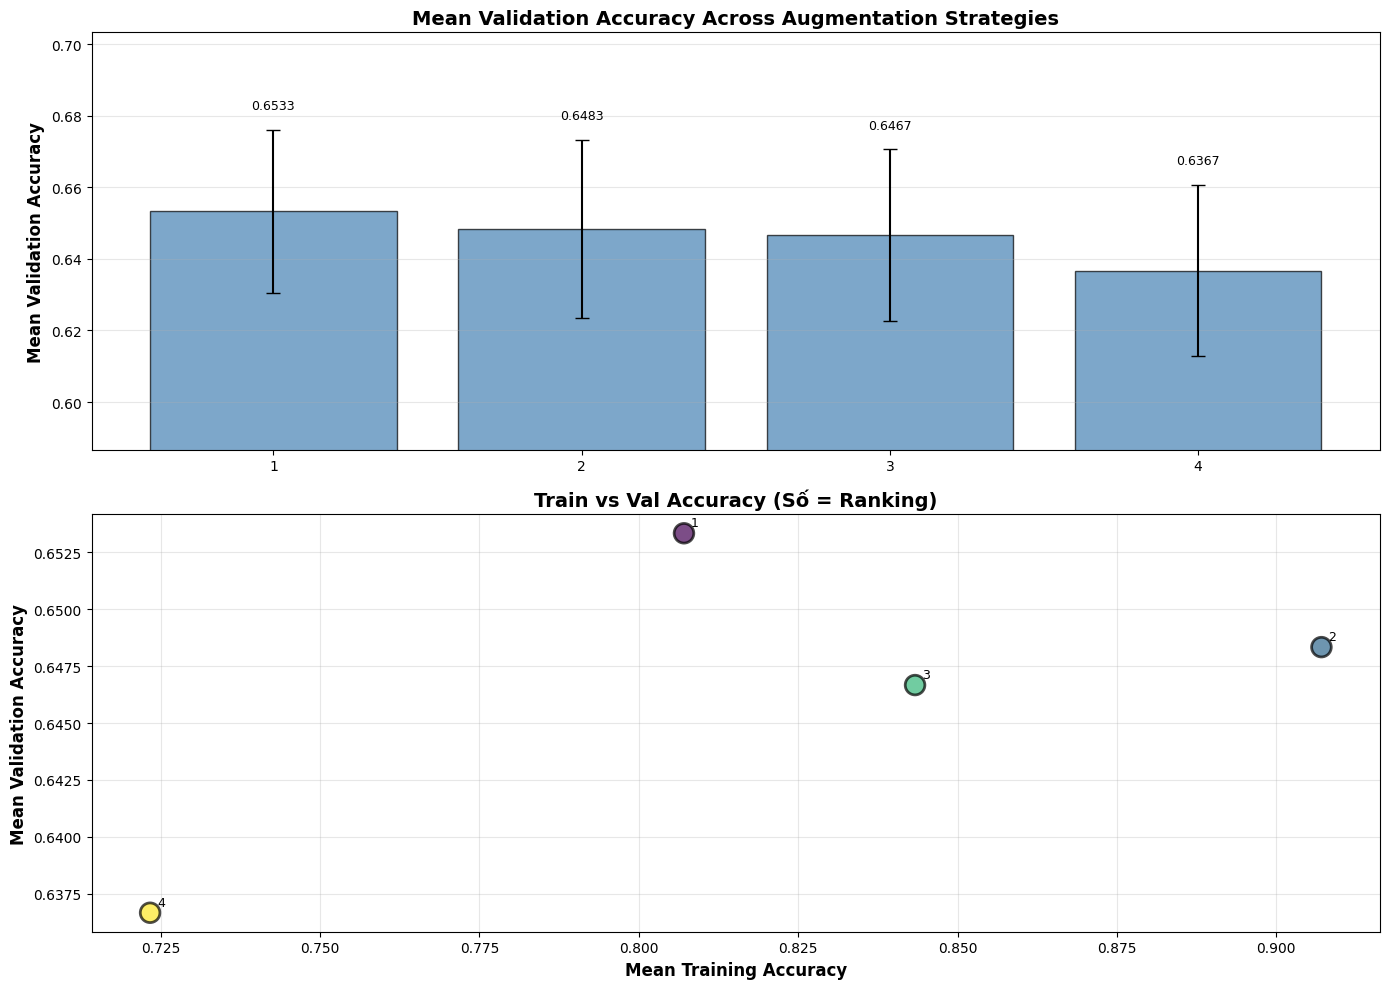

C:\Users\DANG KHOA\AppData\Local\Temp\ipykernel_8728\3743620377.py:52: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = ax.boxplot(fold_data, positions=positions, widths=0.6, patch_artist=True,


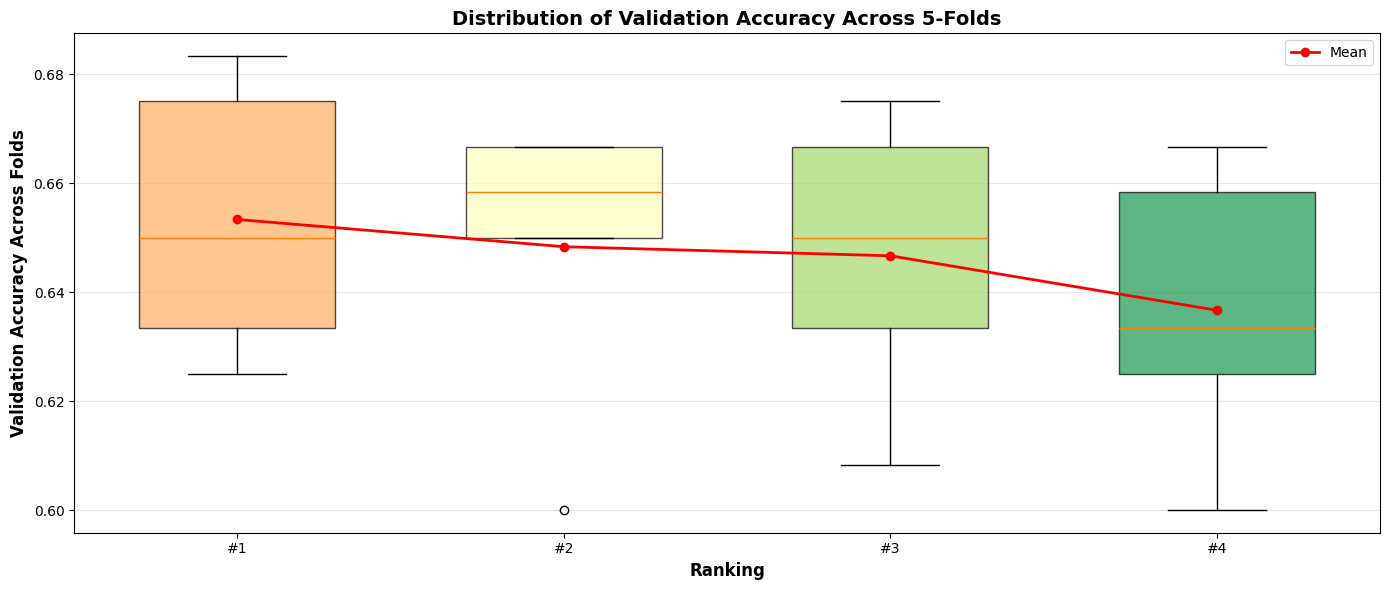

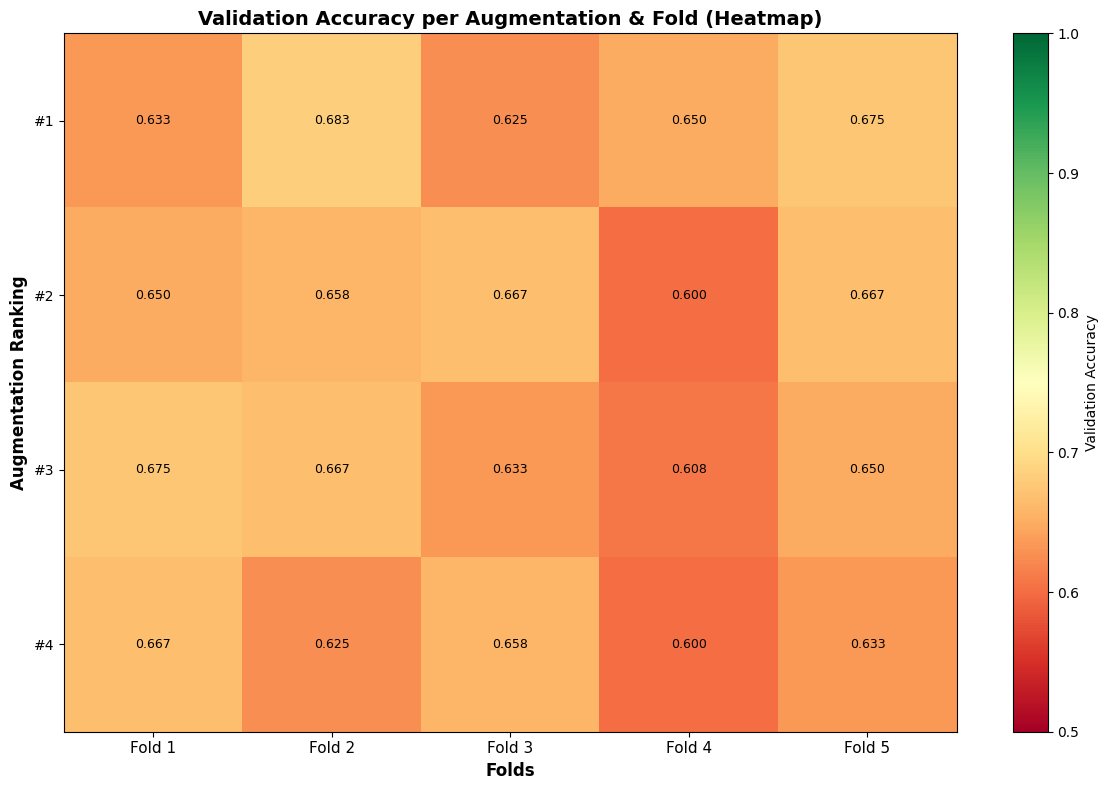


LEGEND:
# 1. HorizontalFlip                                    
# 2. VerticalFlip                                      
# 3. HorizontalFlip                                    
# 4. NO AUGMENTATION                                   


In [22]:
# ============================================================================
# VISUALIZATION - SO SÁNH AUGMENTATION STRATEGIES
# ============================================================================

# Plot 1: Bar chart - Val Accuracy của mỗi augmentation
fig, axes = plt.subplots(2, 1, figsize=(14, 10))

x_pos = np.arange(len(results_df))

# Val Accuracy with error bars
axes[0].bar(x_pos, results_df["Mean Val Acc"], 
           yerr=results_df["Std Val Acc"], 
           capsize=5, alpha=0.7, color='steelblue', edgecolor='black')
axes[0].set_ylabel("Mean Validation Accuracy", fontsize=12, fontweight='bold')
axes[0].set_title("Mean Validation Accuracy Across Augmentation Strategies", fontsize=14, fontweight='bold')
axes[0].set_xticks(x_pos)
axes[0].set_xticklabels(range(1, len(results_df)+1), fontsize=10)
axes[0].grid(True, axis='y', alpha=0.3)
axes[0].set_ylim([min(results_df["Mean Val Acc"]) - 0.05, max(results_df["Mean Val Acc"]) + 0.05])

# Thêm giá trị trên mỗi bar
for i, (idx, row) in enumerate(results_df.iterrows()):
    axes[0].text(i, row["Mean Val Acc"] + row["Std Val Acc"] + 0.005, 
                f'{row["Mean Val Acc"]:.4f}', ha='center', va='bottom', fontsize=9)

# Train vs Val Accuracy scatter
colors = plt.cm.viridis(np.linspace(0, 1, len(results_df)))
axes[1].scatter(results_df["Mean Train Acc"], results_df["Mean Val Acc"], 
               s=200, c=range(len(results_df)), cmap='viridis', edgecolor='black', linewidth=2, alpha=0.7)

# Thêm annotation
for i, (idx, row) in enumerate(results_df.iterrows()):
    axes[1].annotate(f"{i+1}", 
                    xy=(row["Mean Train Acc"], row["Mean Val Acc"]),
                    xytext=(5, 5), textcoords='offset points', fontsize=9)

axes[1].set_xlabel("Mean Training Accuracy", fontsize=12, fontweight='bold')
axes[1].set_ylabel("Mean Validation Accuracy", fontsize=12, fontweight='bold')
axes[1].set_title("Train vs Val Accuracy (Số = Ranking)", fontsize=14, fontweight='bold')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Plot 2: Boxplot - Phân bố accuracy trên các fold
fig, ax = plt.subplots(figsize=(14, 6))

# Tạo data cho boxplot
fold_data = [augmentation_results["all_fold_val_acc"][i] for i in np.argsort(augmentation_results["avg_val_acc"])[::-1]]
positions = np.arange(1, len(fold_data) + 1)

bp = ax.boxplot(fold_data, positions=positions, widths=0.6, patch_artist=True,
               labels=[f"#{i+1}" for i in range(len(fold_data))])

# Tô màu boxes
colors_box = plt.cm.RdYlGn(np.linspace(0.3, 0.9, len(fold_data)))
for patch, color in zip(bp['boxes'], colors_box):
    patch.set_facecolor(color)
    patch.set_alpha(0.7)

ax.set_ylabel("Validation Accuracy Across Folds", fontsize=12, fontweight='bold')
ax.set_xlabel("Ranking", fontsize=12, fontweight='bold')
ax.set_title("Distribution of Validation Accuracy Across 5-Folds", fontsize=14, fontweight='bold')
ax.grid(True, axis='y', alpha=0.3)

# Thêm mean value
means = [np.mean(fold_data[i]) for i in range(len(fold_data))]
ax.plot(positions, means, 'ro-', linewidth=2, markersize=6, label='Mean')
ax.legend()

plt.tight_layout()
plt.show()

# Plot 3: Heatmap - Val Accuracy trên từng fold
fig, ax = plt.subplots(figsize=(12, 8))

# Tạo matrix: rows = augmentation (sorted), cols = folds
fold_matrix = np.array([augmentation_results["all_fold_val_acc"][i] for i in np.argsort(augmentation_results["avg_val_acc"])[::-1]])
aug_labels = [results_df.iloc[i]["Augmentation"] for i in range(len(results_df))]

im = ax.imshow(fold_matrix, cmap='RdYlGn', aspect='auto', vmin=0.5, vmax=1.0)

ax.set_xticks(np.arange(5))
ax.set_yticks(np.arange(len(aug_labels)))
ax.set_xticklabels([f"Fold {i+1}" for i in range(5)], fontsize=11)
ax.set_yticklabels([f"#{i+1}" for i in range(len(aug_labels))], fontsize=10)

ax.set_xlabel("Folds", fontsize=12, fontweight='bold')
ax.set_ylabel("Augmentation Ranking", fontsize=12, fontweight='bold')
ax.set_title("Validation Accuracy per Augmentation & Fold (Heatmap)", fontsize=14, fontweight='bold')

# Thêm text annotations
for i in range(len(aug_labels)):
    for j in range(5):
        text = ax.text(j, i, f'{fold_matrix[i, j]:.3f}',
                      ha="center", va="center", color="black", fontsize=9)

plt.colorbar(im, ax=ax, label='Validation Accuracy')
plt.tight_layout()
plt.show()

# Print legend
print("\nLEGEND:")
for i, (idx, row) in enumerate(results_df.iterrows()):
    print(f"#{i+1:2d}. {row['Augmentation']:50s}")


In [23]:
# ============================================================================
# TIỂU KẾT + LƯU KẾT QUẢ
# ============================================================================

print("=" * 100)
print("TĨM TẮT KẾT QUẢ VÉT AUGMENTATION")
print("=" * 100)

best_idx = results_df["Mean Val Acc"].idxmax()
best_row = results_df.loc[best_idx]
baseline_row = results_df[results_df["Augmentation"] == "NO AUGMENTATION"].iloc[0]

print(f"\n✓ BEST AUGMENTATION: {best_row['Augmentation']}")
print(f"  Val Accuracy: {best_row['Mean Val Acc']:.4f} ± {best_row['Std Val Acc']:.4f}")
print(f"  Train Accuracy: {best_row['Mean Train Acc']:.4f}")

improvement = (best_row['Mean Val Acc'] - baseline_row['Mean Val Acc']) / baseline_row['Mean Val Acc'] * 100
print(f"\n✓ SO SÁNH VỚI BASELINE (NO AUGMENTATION):")
print(f"  Baseline Val Acc: {baseline_row['Mean Val Acc']:.4f} ± {baseline_row['Std Val Acc']:.4f}")
print(f"  Improvement: {improvement:+.2f}%")

print(f"\n✓ TỔNG SỐ AUGMENTATION ĐÃ TEST: {len(results_df)}")

# Lưu kết quả vào CSV
csv_path = os.path.join(CHECKPOINT_DIR, "augmentation_results.csv")
results_df.to_csv(csv_path, index=False)
print(f"\n✓ Kết quả đã lưu vào: {csv_path}")

# Lưu kết quả chi tiết vào JSON
json_path = os.path.join(CHECKPOINT_DIR, "augmentation_results_detailed.json")
json_results = {
    "augmentation_results": [
        {
            "augmentation": aug_combo,
            "avg_val_acc": float(augmentation_results["avg_val_acc"][i]),
            "std_val_acc": float(augmentation_results["std_val_acc"][i]),
            "avg_train_acc": float(augmentation_results["avg_train_acc"][i]),
            "fold_accs": [float(x) for x in augmentation_results["all_fold_val_acc"][i]]
        }
        for i, aug_combo in enumerate(augmentation_results["aug_combo"])
    ],
    "best_augmentation": best_row["Augmentation"],
    "best_val_acc": float(best_row["Mean Val Acc"]),
    "timestamp": datetime.now().isoformat()
}

with open(json_path, 'w') as f:
    json.dump(json_results, f, indent=2)
print(f"✓ Chi tiết kết quả đã lưu vào: {json_path}")

print("\n" + "=" * 100)


TĨM TẮT KẾT QUẢ VÉT AUGMENTATION

✓ BEST AUGMENTATION: HorizontalFlip
  Val Accuracy: 0.6533 ± 0.0227
  Train Accuracy: 0.8071

✓ SO SÁNH VỚI BASELINE (NO AUGMENTATION):
  Baseline Val Acc: 0.6367 ± 0.0239
  Improvement: +2.62%

✓ TỔNG SỐ AUGMENTATION ĐÃ TEST: 4

✓ Kết quả đã lưu vào: G:\My Drive\NCKH\git\checkpoints\augmentation_results.csv
✓ Chi tiết kết quả đã lưu vào: G:\My Drive\NCKH\git\checkpoints\augmentation_results_detailed.json



In [24]:
# ============================================================================
# CHỌN AUGMENTATION TỐT NHẤT + TRAINING FINAL + SUBMISSION
# ============================================================================

# Tự động chọn augmentation tốt nhất
best_augmentation = best_row["Augmentation"]
best_aug_combo = [a.strip() for a in best_augmentation.split('+')] if best_augmentation != "NO AUGMENTATION" else []

print(f"\n{'=' * 100}")
print(f"TRAINING FINAL MODEL VỚI BEST AUGMENTATION")
print(f"{'=' * 100}\n")

print(f"Selected Augmentation: {best_augmentation}")
print(f"Expected Val Accuracy: {best_row['Mean Val Acc']:.4f} ± {best_row['Std Val Acc']:.4f}\n")

# ============================================================================
# TRAINING FINAL MODEL - K-FOLD CROSS VALIDATION
# ============================================================================

print("=" * 100)
print("K-FOLD CROSS VALIDATION TRAINING WITH BEST AUGMENTATION")
print("=" * 100 + "\n")

# Create transforms with best augmentation
tfm_train_best = create_transforms_from_combo(best_aug_combo, CONFIG["img_size"])
tfm_val_best = transforms.Compose([
    transforms.Resize((CONFIG["img_size"], CONFIG["img_size"])),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Initialize results tracking
fold_results_final = {
    "fold": [],
    "train_acc": [],
    "val_acc": [],
    "train_loss": [],
    "val_loss": []
}

overall_best_val_acc_final = 0.0
best_fold_model_path_final = None

for fold_idx, (train_files, val_files) in enumerate(kfold_splits, 1):
    print(f"\n{'=' * 100}")
    print(f"FOLD {fold_idx}/{n_splits}")
    print(f"{'=' * 100}")
    
    # Create datasets for this fold
    train_ds = RGBDataset(TRAIN_RGB_DIR, transform=tfm_train_best, file_list=train_files)
    val_ds = RGBDataset(TRAIN_RGB_DIR, transform=tfm_val_best, file_list=val_files)
    
    # DataLoaders
    train_loader = DataLoader(train_ds, batch_size=CONFIG["batch_size"], shuffle=True, num_workers=0)
    val_loader = DataLoader(val_ds, batch_size=CONFIG["batch_size"], shuffle=False, num_workers=0)
    
    print(f"Train: {len(train_ds)}, Val: {len(val_ds)}")
    
    # Reinitialize model for each fold
    model = create_model(CONFIG["num_classes"], pretrained=True)
    model = model.to(device)
    
    # Loss & Optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=CONFIG["lr"])
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=3)
    
    # Training loop for this fold
    best_val_acc = 0.0
    best_train_acc_at_best_val = 0.0
    fold_model_path = os.path.join(CHECKPOINT_DIR, f"best_rgb_efficientnet_b0_fold{fold_idx}_final.pth")
    
    history = {"train_loss": [], "train_acc": [], "val_loss": [], "val_acc": []}
    
    for epoch in range(1, CONFIG["epochs"] + 1):
        train_loss, train_acc = train_one_epoch(model, train_loader, criterion, optimizer)
        val_loss, val_acc = evaluate(model, val_loader, criterion)
        
        scheduler.step(val_acc)
        
        history["train_loss"].append(train_loss)
        history["train_acc"].append(train_acc)
        history["val_loss"].append(val_loss)
        history["val_acc"].append(val_acc)
        
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            best_train_acc_at_best_val = train_acc
            torch.save(model.state_dict(), fold_model_path)
            print(f"Epoch {epoch:02d} | train_acc={train_acc:.4f} val_acc={val_acc:.4f} ⭐")
        else:
            print(f"Epoch {epoch:02d} | train_acc={train_acc:.4f} val_acc={val_acc:.4f}")
    
    # Save fold results
    fold_results_final["fold"].append(fold_idx)
    fold_results_final["train_loss"].append(history["train_loss"][-1])
    fold_results_final["train_acc"].append(history["train_acc"][-1])
    fold_results_final["val_loss"].append(history["val_loss"][-1])
    fold_results_final["val_acc"].append(history["val_acc"][-1])
    
    print(f"\n✓ Fold {fold_idx} Best val_acc: {best_val_acc:.4f}")
    print(f"✓ Model saved to: {fold_model_path}")
    
    # Track best model across all folds
    if best_val_acc > overall_best_val_acc_final:
        overall_best_val_acc_final = best_val_acc
        best_fold_model_path_final = fold_model_path
        best_fold_idx_final = fold_idx

# Print K-Fold Summary
print("\n" + "=" * 100)
print("K-FOLD CROSS VALIDATION SUMMARY - FINAL")
print("=" * 100)
for i in range(len(fold_results_final["fold"])):
    print(f"Fold {fold_results_final['fold'][i]}: val_acc={fold_results_final['val_acc'][i]:.4f}, train_acc={fold_results_final['train_acc'][i]:.4f}")

avg_val_acc_final = np.mean(fold_results_final["val_acc"])
std_val_acc_final = np.std(fold_results_final["val_acc"])
print(f"\nMean Val Accuracy: {avg_val_acc_final:.4f} ± {std_val_acc_final:.4f}")
print(f"Best Overall Val Accuracy: {overall_best_val_acc_final:.4f} (Fold {best_fold_idx_final})")
print(f"Best Model: {best_fold_model_path_final}")

print(f"\n✓ AUGMENTATION USED: {best_augmentation}")



TRAINING FINAL MODEL VỚI BEST AUGMENTATION

Selected Augmentation: HorizontalFlip
Expected Val Accuracy: 0.6533 ± 0.0227

K-FOLD CROSS VALIDATION TRAINING WITH BEST AUGMENTATION


FOLD 1/5
Train: 480, Val: 120
Epoch 01 | train_acc=0.4167 val_acc=0.5833 ⭐
Epoch 02 | train_acc=0.5771 val_acc=0.6333 ⭐
Epoch 03 | train_acc=0.6542 val_acc=0.6250
Epoch 04 | train_acc=0.7417 val_acc=0.5667
Epoch 05 | train_acc=0.7979 val_acc=0.6333
Epoch 06 | train_acc=0.8938 val_acc=0.6083
Epoch 07 | train_acc=0.9583 val_acc=0.7000 ⭐


OSError: [Errno 28] No space left on device

## 5. Training

In [ ]:
# K-Fold Cross Validation Training
print("\n" + "="*60)
print("K-FOLD CROSS VALIDATION TRAINING")
print("="*60 + "\n")

overall_best_val_acc = 0.0
best_fold_model_path = None

for fold_idx, (train_files, val_files) in enumerate(kfold_splits, 1):
    print(f"\n{'='*60}")
    print(f"FOLD {fold_idx}/{n_splits}")
    print(f"{'='*60}")
    
    # Initialize WandB for this fold
    wandb.init(
        project="beyond-visible-spectrum",
        name=f"baseline_rgb_{CONFIG['model_name']}_fold{fold_idx}",
        config=CONFIG
    )
    
    # Create datasets for this fold
    train_ds = RGBDataset(TRAIN_RGB_DIR, transform=tfm_train, file_list=train_files)
    val_ds = RGBDataset(TRAIN_RGB_DIR, transform=tfm_val, file_list=val_files)
    
    # DataLoaders
    train_loader = DataLoader(train_ds, batch_size=CONFIG["batch_size"], shuffle=True, num_workers=0)
    val_loader = DataLoader(val_ds, batch_size=CONFIG["batch_size"], shuffle=False, num_workers=0)
    
    print(f"Train: {len(train_ds)}, Val: {len(val_ds)}")
    
    # Reinitialize model for each fold
    model = create_model(CONFIG["num_classes"], pretrained=True)
    model = model.to(device)
    
    # Loss & Optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=CONFIG["lr"])
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=3)
    
    # Training loop for this fold
    best_val_acc = 0.0
    fold_model_path = os.path.join(CHECKPOINT_DIR, f"best_rgb_resnet18_fold{fold_idx}.pth")
    
    history = {"train_loss": [], "train_acc": [], "val_loss": [], "val_acc": []}
    
    for epoch in range(1, CONFIG["epochs"] + 1):
        train_loss, train_acc = train_one_epoch(model, train_loader, criterion, optimizer)
        val_loss, val_acc = evaluate(model, val_loader, criterion)
        
        scheduler.step(val_acc)
        
        wandb.log({
            "epoch": epoch,
            "fold": fold_idx,
            "train_loss": train_loss,
            "train_acc": train_acc,
            "val_loss": val_loss,
            "val_acc": val_acc,
            "lr": optimizer.param_groups[0]['lr']
        })
        
        history["train_loss"].append(train_loss)
        history["train_acc"].append(train_acc)
        history["val_loss"].append(val_loss)
        history["val_acc"].append(val_acc)
        
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            torch.save(model.state_dict(), fold_model_path)
            print(f"Epoch {epoch:02d} | train_acc={train_acc:.4f} val_acc={val_acc:.4f} ⭐")
        else:
            print(f"Epoch {epoch:02d} | train_acc={train_acc:.4f} val_acc={val_acc:.4f}")
    
    wandb.finish()
    
    # Save fold results
    fold_results["fold"].append(fold_idx)
    fold_results["train_loss"].append(history["train_loss"][-1])
    fold_results["train_acc"].append(history["train_acc"][-1])
    fold_results["val_loss"].append(history["val_loss"][-1])
    fold_results["val_acc"].append(history["val_acc"][-1])
    
    print(f"\n✓ Fold {fold_idx} Best val_acc: {best_val_acc:.4f}")
    print(f"✓ Model saved to: {fold_model_path}")
    
    # Track best model across all folds
    if best_val_acc > overall_best_val_acc:
        overall_best_val_acc = best_val_acc
        best_fold_model_path = fold_model_path

# Print K-Fold Summary
print("\n" + "="*60)
print("K-FOLD CROSS VALIDATION SUMMARY")
print("="*60)
for i in range(len(fold_results["fold"])):
    print(f"Fold {fold_results['fold'][i]}: val_acc={fold_results['val_acc'][i]:.4f}, train_acc={fold_results['train_acc'][i]:.4f}")

avg_val_acc = np.mean(fold_results["val_acc"])
std_val_acc = np.std(fold_results["val_acc"])
print(f"\nMean Val Accuracy: {avg_val_acc:.4f} ± {std_val_acc:.4f}")
print(f"Best Overall Val Accuracy: {overall_best_val_acc:.4f}")
print(f"Best Model: {best_fold_model_path}")

In [ ]:
# Plot K-Fold Results
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

folds = fold_results["fold"]

# Val Accuracy across folds
axes[0].plot(folds, fold_results["val_acc"], marker='o', label="Val Accuracy", linewidth=2, markersize=8)
axes[0].axhline(y=np.mean(fold_results["val_acc"]), color='r', linestyle='--', label=f'Mean: {np.mean(fold_results["val_acc"]):.4f}')
axes[0].fill_between(folds, 
                      np.array(fold_results["val_acc"]) - np.std(fold_results["val_acc"]),
                      np.array(fold_results["val_acc"]) + np.std(fold_results["val_acc"]),
                      alpha=0.2)
axes[0].set_xlabel("Fold")
axes[0].set_ylabel("Accuracy")
axes[0].set_title("Validation Accuracy across Folds")
axes[0].legend()
axes[0].grid(True)
axes[0].set_xticks(folds)

# Train vs Val accuracy for each fold
x = np.arange(len(folds))
width = 0.35
axes[1].bar(x - width/2, fold_results["train_acc"], width, label="Train Acc", alpha=0.8)
axes[1].bar(x + width/2, fold_results["val_acc"], width, label="Val Acc", alpha=0.8)
axes[1].set_xlabel("Fold")
axes[1].set_ylabel("Accuracy")
axes[1].set_title("Train vs Val Accuracy per Fold")
axes[1].set_xticks(x)
axes[1].set_xticklabels(folds)
axes[1].legend()
axes[1].grid(True, axis='y')

plt.tight_layout()
plt.show()

## 6. Evaluation

In [ ]:
# Load best model from best fold for evaluation
# Find which fold had the best model
best_fold_idx = fold_results["val_acc"].index(max(fold_results["val_acc"])) + 1
best_train_files, best_val_files = kfold_splits[best_fold_idx - 1]

# Recreate best fold's validation dataset
val_ds = RGBDataset(TRAIN_RGB_DIR, transform=tfm_val, file_list=best_val_files)
val_loader = DataLoader(val_ds, batch_size=CONFIG["batch_size"], shuffle=False, num_workers=0)

print(f"\n{'='*60}")
print(f"EVALUATION on Best Fold ({best_fold_idx})")
print(f"Val samples: {len(val_ds)}")
print(f"{'='*60}\n")

# Load best model
model = create_model(CONFIG["num_classes"], pretrained=True)
model = model.to(device)
model.load_state_dict(torch.load(best_fold_model_path, map_location=device))
model.eval()

# Get predictions on validation set
y_true, y_pred = [], []

with torch.no_grad():
    for images, labels in val_loader:
        images = images.to(device)
        outputs = model(images)
        preds = outputs.argmax(dim=1).cpu().numpy()
        
        y_true.extend(labels.numpy())
        y_pred.extend(preds)

y_true = np.array(y_true)
y_pred = np.array(y_pred)

# Classification report
class_names = [val_ds.idx_to_class[i] for i in range(CONFIG["num_classes"])]
print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=class_names))

In [ ]:
# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(8, 6))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title("Confusion Matrix - RGB Baseline")
plt.colorbar()

tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names, rotation=45)
plt.yticks(tick_marks, class_names)

# Add text annotations
thresh = cm.max() / 2.
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, format(cm[i, j], 'd'),
                 ha="center", va="center",
                 color="white" if cm[i, j] > thresh else "black",
                 fontsize=14)

plt.xlabel("Predicted")
plt.ylabel("True")
plt.tight_layout()
plt.show()

In [ ]:
# Visualize Misclassified Images with proper denormalization
from collections import defaultdict

# Get predictions with image indices
misclassified = defaultdict(list)

print("=== Collecting Misclassified Images ===\n")

with torch.no_grad():
    val_dl = DataLoader(val_ds, batch_size=1, shuffle=False, num_workers=0)
    
    for idx, (images, labels) in enumerate(val_dl):
        images = images.to(device)
        outputs = model(images)
        pred = outputs.argmax(dim=1).cpu().numpy()[0]
        true = labels.numpy()[0]
        
        if pred != true:
            true_label = val_ds.idx_to_class[true]
            pred_label = val_ds.idx_to_class[pred]
            misclassified[(true_label, pred_label)].append(idx)

print(f"Total misclassified: {sum(len(v) for v in misclassified.values())}")
print("\nBreakdown by type:")
for (true_lbl, pred_lbl), indices in sorted(misclassified.items()):
    print(f"  {true_lbl} → {pred_lbl}: {len(indices)} images")

# Denormalization constants
IMAGENET_MEAN = np.array([0.485, 0.456, 0.406])
IMAGENET_STD = np.array([0.229, 0.224, 0.225])

def denormalize_image(img_tensor):
    """Denormalize ImageNet-normalized image tensor"""
    img_np = img_tensor.numpy().transpose(1, 2, 0)
    img_np = img_np * IMAGENET_STD + IMAGENET_MEAN
    img_np = np.clip(img_np, 0, 1)
    return img_np

# Visualize
print("\n=== Visualizing Misclassified Images ===\n")

for (true_lbl, pred_lbl), indices in sorted(misclassified.items()):
    num_show = min(10, len(indices))
    fig, axes = plt.subplots(1, num_show, figsize=(20, 4))
    
    if num_show == 1:
        axes = [axes]
    
    fig.suptitle(f"Actual: {true_lbl} → Predicted: {pred_lbl} ({len(indices)} total)", 
                 fontsize=14, fontweight='bold')
    
    for i, idx in enumerate(indices[:num_show]):
        img_tensor, _ = val_ds[idx]
        img_display = denormalize_image(img_tensor)
        
        axes[i].imshow(img_display)
        axes[i].set_title(f"Sample {i+1}")
        axes[i].axis('off')
    
    plt.tight_layout()
    plt.show()


In [ ]:
import math
# Visualize specific misclassification: Health → Rust
print("=" * 60)
print("ANALYSIS: Health (Thực tế) → Rust (Dự đoán)")
print("=" * 60)

true_lbl, pred_lbl = "Health", "Rust"

if (true_lbl, pred_lbl) in misclassified:
    indices = misclassified[(true_lbl, pred_lbl)]
    num_show = min(29, len(indices))
    
    print(f"\nTổng cộng: {len(indices)} ảnh Health dự đoán sai thành Rust\n")
    
    cols = 5
    rows = math.ceil(num_show / cols)

    fig, axes = plt.subplots(rows, cols, figsize=(5*cols, 5*rows))
    axes = axes.flatten()
    
    fig.suptitle(f"Health (Thực tế) → Rust (Dự đoán) - {len(indices)} images", 
                 fontsize=16, fontweight='bold', color='red')
    
    for i, idx in enumerate(indices[:num_show]):
        img_tensor, _ = val_ds[idx]
        img_display = denormalize_image(img_tensor)
        
        axes[i].imshow(img_display)
        axes[i].set_title(f"Sample {i+1}", fontsize=12)
        axes[i].axis('off')
    
    # Hide extra subplots
    for i in range(num_show, len(axes)):
        axes[i].axis('off')
    
    plt.tight_layout()
    plt.show()
    
    print(f"✓ Hiển thị {num_show} ảnh mẫu từ {len(indices)} tổng cộng")
else:
    print(f"❌ Không tìm thấy misclassification: {true_lbl} → {pred_lbl}")


## 7. Inference & Submission

In [ ]:
# Check if test directory exists
if os.path.exists(TEST_RGB_DIR):
    # Create test dataset
    test_ds = RGBTestDataset(TEST_RGB_DIR, transform=tfm_val)
    test_loader = DataLoader(test_ds, batch_size=CONFIG["batch_size"], shuffle=False, num_workers=0)
    
    print(f"Test samples: {len(test_ds)}")
else:
    print(f"⚠️ Test directory not found: {TEST_RGB_DIR}")
    print("Skipping test inference...")

In [ ]:
# Run inference on test set
if os.path.exists(TEST_RGB_DIR):
    model.eval()
    predictions = []
    filenames = []
    
    idx_to_class = val_ds.idx_to_class
    
    with torch.no_grad():
        for images, fnames in test_loader:
            images = images.to(device)
            outputs = model(images)
            preds = outputs.argmax(dim=1).cpu().numpy()
            
            # Convert to class names
            pred_labels = [idx_to_class[p] for p in preds]
            
            predictions.extend(pred_labels)
            filenames.extend(fnames)
    
    print(f"✓ Predicted {len(predictions)} test samples")
    print(f"Sample predictions: {list(zip(filenames[:5], predictions[:5]))}")

In [ ]:
# import pandas as pd

# df = pd.read_csv(r"D:\HocTap\NCKH_ThayDoNhuTai\Challenges\checkpoints\submission_task1_rgb.csv")

# label_map = {
#     "rust": "Rust",
#     "other": "Other",
#     "healthy": "Health"
# }

# df["label"] = df["label"].map(label_map)

# df.to_csv("submission_task1_rgb_FIXED.csv", index=False)
# print(df.head())


In [ ]:
import os
import pandas as pd

if os.path.exists(TEST_RGB_DIR):
    submission_df = pd.DataFrame({
        "ID": filenames,      # TÊN CỘT ĐÚNG
        "label": predictions        # Rust / Other / Health
    })

    # sort cho đẹp (không bắt buộc nhưng nên làm)
    submission_df = submission_df.sort_values("ID").reset_index(drop=True)

    submission_path = os.path.join(CHECKPOINT_DIR, "submission_rgb.csv")
    submission_df.to_csv(submission_path, index=False)

    print(f"✓ Saved submission to: {submission_path}")
    print(f"✓ Total predictions: {len(submission_df)}")

    print("\nFirst 10 rows:")
    print(submission_df.head(10))

    print("\nLabel distribution:")
    print(submission_df["label"].value_counts())
else:
    print("⚠️ No test data - submission not created")


## 8. Overfitting Analysis (Optional)

In [ ]:
# import pandas as pd

# # Giả sử submission_df là dataframe cũ của bạn
# submission_df = pd.DataFrame({
#     'Id': filenames,         # Đổi từ 'filename' sang 'Id'
#     'Category': formatted_labels  # Đổi từ 'label' sang 'Category' (kiểm tra lại tên cột này của BTC)
# })

# # Lưu file mới
# submission_df.to_csv('submission_task1_final.csv', index=False)

In [ ]:
# Check for potential overfitting signs
print("=== Overfitting Analysis ===")
print(f"\nDataset size: {len(base_ds)} images")
print(f"Train/Val split: {len(train_ds)}/{len(val_ds)}")

# Gap between train and val accuracy
final_train_acc = history["train_acc"][-1]
final_val_acc = history["val_acc"][-1]
gap = final_train_acc - final_val_acc

print(f"\nFinal Train Accuracy: {final_train_acc:.4f}")
print(f"Final Val Accuracy: {final_val_acc:.4f}")
print(f"Gap (Train - Val): {gap:.4f}")

if gap > 0.1:
    print("⚠️ Large gap detected - possible overfitting!")
    print("   Suggestions: More augmentation, dropout, early stopping")
elif final_val_acc > 0.95:
    print("⚠️ Very high val_acc - check for data leakage!")
else:
    print("✓ Gap looks reasonable")

In [ ]:
# Re-predict misclassified images
print("=== Re-predicting Misclassified Images ===\n")

# Collect all misclassified images with their predictions
misclassified_data = []

with torch.no_grad():
    val_dl = DataLoader(val_ds, batch_size=1, shuffle=False, num_workers=0)
    
    for idx, (images, labels) in enumerate(val_dl):
        images = images.to(device)
        outputs = model(images)
        
        # Get top-k predictions
        probabilities = torch.softmax(outputs, dim=1)
        top_k_probs, top_k_indices = torch.topk(probabilities, 3, dim=1)
        
        pred = outputs.argmax(dim=1).cpu().numpy()[0]
        true = labels.numpy()[0]
        
        if pred != true:
            true_label = val_ds.idx_to_class[true]
            pred_label = val_ds.idx_to_class[pred]
            confidence = probabilities[0, pred].item()
            
            misclassified_data.append({
                'idx': idx,
                'true_label': true_label,
                'pred_label': pred_label,
                'confidence': confidence,
                'top3_labels': [val_ds.idx_to_class[i.item()] for i in top_k_indices[0]],
                'top3_probs': [p.item() for p in top_k_probs[0]],
                'filename': val_ds.files[idx]
            })

# Sort by confidence (most confident wrong predictions first)
misclassified_data.sort(key=lambda x: x['confidence'], reverse=True)

print(f"Total misclassified images: {len(misclassified_data)}\n")

# Display detailed predictions
print("Top 10 Most Confident Misclassified Predictions:")
print("-" * 100)
for i, item in enumerate(misclassified_data[:10]):
    print(f"{i+1}. Image: {item['filename']}")
    print(f"   True Label: {item['true_label']}")
    print(f"   Predicted: {item['pred_label']} (Confidence: {item['confidence']:.4f})")
    print(f"   Top-3 Predictions:")
    for j, (lbl, prob) in enumerate(zip(item['top3_labels'], item['top3_probs'])):
        print(f"      {j+1}. {lbl}: {prob:.4f}")
    print()

# Visualize re-predictions
print("\n=== Visualizing Re-Predictions ===\n")

for (true_lbl, pred_lbl), _ in sorted(misclassified.items()):
    items = [item for item in misclassified_data if item['true_label'] == true_lbl and item['pred_label'] == pred_lbl]
    
    if not items:
        continue
    
    num_show = min(5, len(items))
    fig, axes = plt.subplots(2, num_show, 
                             figsize=(20, 8),
                             squeeze=False)
    
    fig.suptitle(f"Re-prediction: {true_lbl} → {pred_lbl} ({len(items)} total)", 
                 fontsize=14, fontweight='bold')
    
    for i in range(num_show):
        item = items[i]
        idx = item['idx']
        img_tensor, _ = val_ds[idx]
        img_display = denormalize_image(img_tensor)
        
        # Image
        axes[0, i].imshow(img_display)
        axes[0, i].set_title(f"True: {item['true_label']}", fontweight='bold')
        axes[0, i].axis('off')
        
        # Predictions bar chart
        top3_labels = item['top3_labels']
        top3_probs = item['top3_probs']
        colors = ['red' if lbl == item['pred_label'] else 'lightblue' for lbl in top3_labels]
        
        axes[1, i].barh(top3_labels, top3_probs, color=colors)
        axes[1, i].set_xlim(0, 1)
        axes[1, i].set_title(f"Pred: {item['pred_label']}\n({item['confidence']:.4f})")
        axes[1, i].set_xlabel("Probability")
        
        for j, (lbl, prob) in enumerate(zip(top3_labels, top3_probs)):
            axes[1, i].text(prob + 0.02, j, f'{prob:.4f}', va='center')
    
    plt.tight_layout()
    plt.show()

In [ ]:
# List all misclassified images by category
print("=" * 80)
print("MISCLASSIFIED IMAGES - ORGANIZED BY TRUE LABEL → PREDICTED LABEL")
print("=" * 80)

# Dictionary to store misclassified images
misclassified_by_type = {}

with torch.no_grad():
    val_dl = DataLoader(val_ds, batch_size=1, shuffle=False, num_workers=0)
    
    for idx, (images, labels) in enumerate(val_dl):
        images = images.to(device)
        outputs = model(images)
        pred = outputs.argmax(dim=1).cpu().numpy()[0]
        true = labels.numpy()[0]
        
        # Only process misclassified
        if pred != true:
            true_label = val_ds.idx_to_class[true]
            pred_label = val_ds.idx_to_class[pred]
            filename = val_ds.files[idx]
            
            # Create key for this misclassification type
            key = f"{true_label} → {pred_label}"
            
            if key not in misclassified_by_type:
                misclassified_by_type[key] = []
            
            misclassified_by_type[key].append(filename)

# Sort and display
total_misclassified = sum(len(v) for v in misclassified_by_type.values())
print(f"\nTOTAL MISCLASSIFIED: {total_misclassified} images\n")

# Display organized by category
for key in sorted(misclassified_by_type.keys()):
    filenames = misclassified_by_type[key]
    print(f"\n{key} ({len(filenames)} images):")
    print("-" * 80)
    for filename in sorted(filenames):
        print(f"  • {filename}")

# Summary
print(f"\n\n{'=' * 80}")
print("SUMMARY")
print("=" * 80)
for key in sorted(misclassified_by_type.keys()):
    print(f"{key}: {len(misclassified_by_type[key])} images")